In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
from pathlib import Path
import numpy as np
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent  
DATA_DIR = PROJECT_ROOT / "data"

In [2]:
df = pd.read_csv(DATA_DIR / "salesdata_uci.csv")
df.head()

,week_start,SKU_NO,sales
0,2020-01-06,P1,11
1,2020-01-06,P2,7
2,2020-01-06,P3,7
3,2020-01-06,P4,12
4,2020-01-06,P5,8


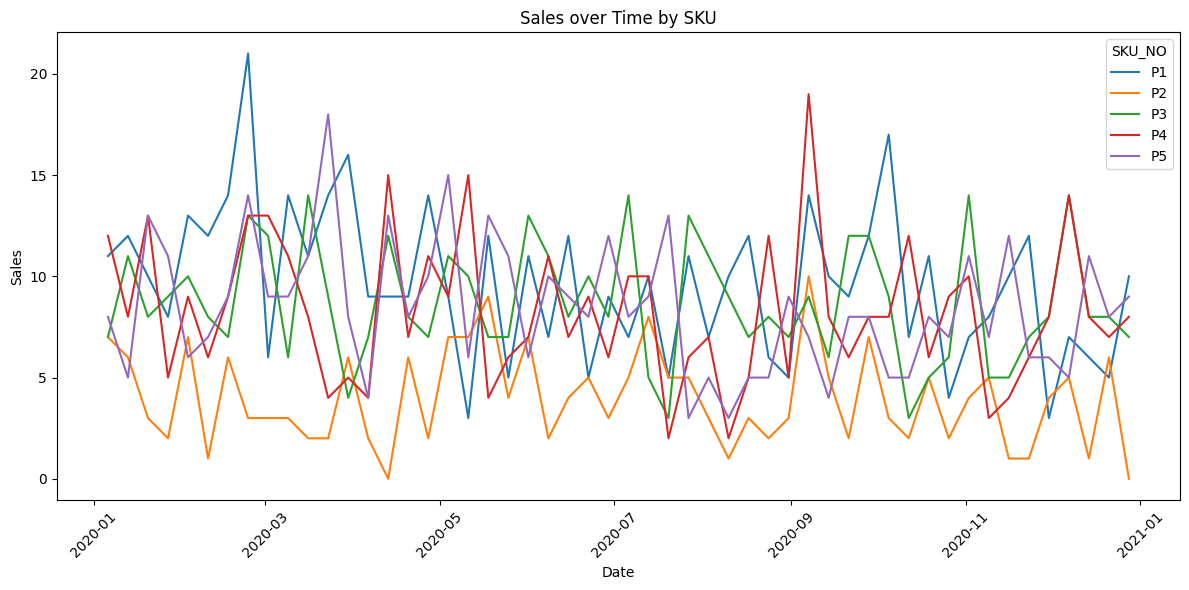

In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

top_skus = df["SKU_NO"].value_counts().head(5).index
filtered_df = df[df["SKU_NO"].isin(top_skus)]

filtered_df = filtered_df.copy()
filtered_df["week_start"] = pd.to_datetime(filtered_df["week_start"])

plt.figure(figsize=(12, 6))

for sku, sku_df in filtered_df.groupby("SKU_NO"):
    plt.plot(sku_df["week_start"], sku_df["sales"], label=sku)

ax = plt.gca()

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

plt.legend(title="SKU_NO")
plt.title("Sales over Time by SKU")
plt.xlabel("Date")
plt.ylabel("Sales")

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [4]:
# length of each time series (number of observations per SKU)
series_lengths = (
    df
    .groupby("SKU_NO")
    .size()
)

num_series = series_lengths.shape[0]
longest = series_lengths.max()
shortest = series_lengths.min()
median_len = int(np.median(series_lengths))

print(f"Number of series: {num_series}")
print(f"Longest series length: {longest}")
print(f"Shortest series length: {shortest}")
print(f"Median series length: {median_len}")


Number of series: 811
Longest series length: 52
Shortest series length: 52
Median series length: 52



=== Correlation Statistics ===
Number of SKUs: 811
Total correlations: 328455
Mean correlation: 0.044
Median correlation: 0.037
Min correlation: -0.640
Max correlation: 0.814
Std correlation: 0.165


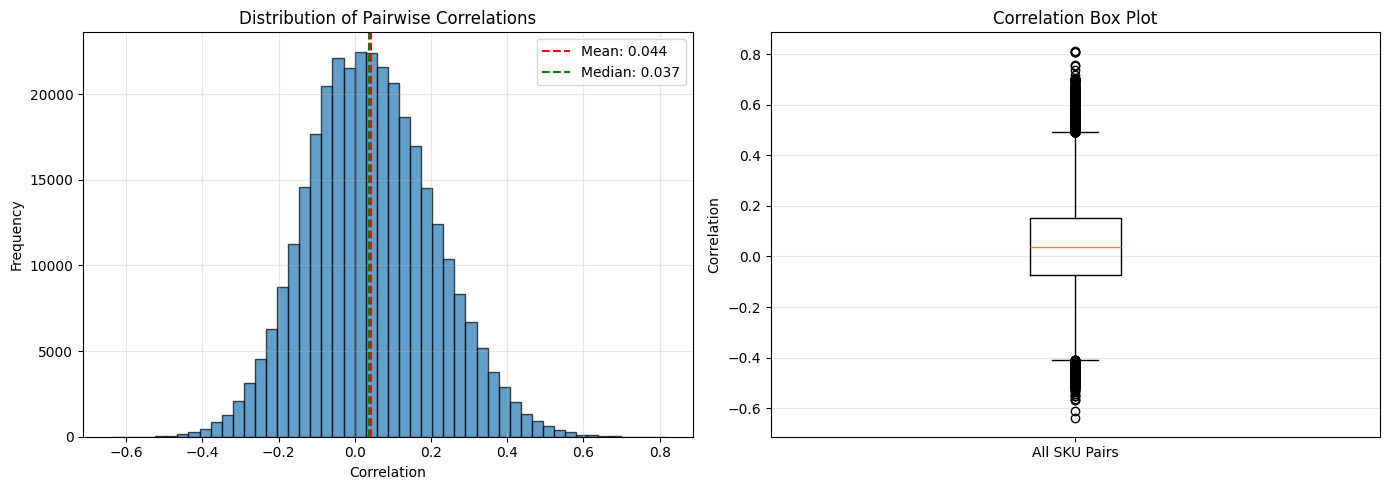


=== Top 20 Most Correlated SKU Pairs ===
P215 <-> P457: 0.814
P351 <-> P646: 0.808
P466 <-> P468: 0.808
P428 <-> P474: 0.808
P218 <-> P682: 0.758
P643 <-> P680: 0.753
P18 <-> P191: 0.738
P380 <-> P682: 0.719
P242 <-> P712: 0.704
P469 <-> P647: 0.704
P469 <-> P655: 0.704
P383 <-> P680: 0.700
P215 <-> P279: 0.700
P471 <-> P680: 0.700
P646 <-> P680: 0.700
P215 <-> P656: 0.700
P251 <-> P468: 0.700
P251 <-> P253: 0.700
P428 <-> P680: 0.700
P252 <-> P778: 0.697


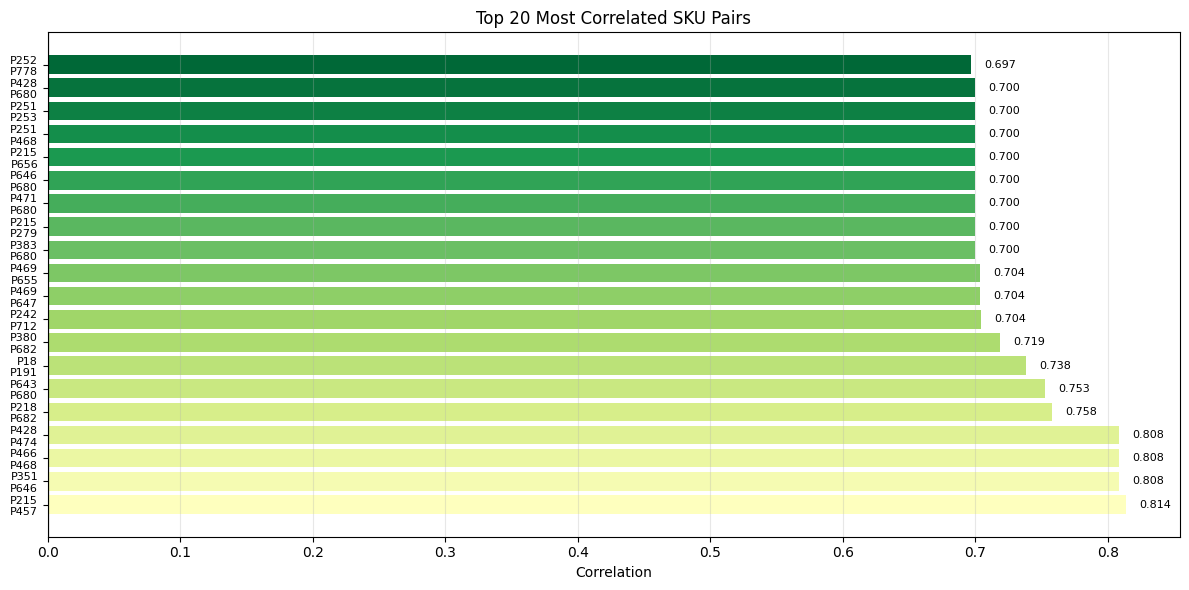


=== Creating heatmap for top 28 SKUs ===


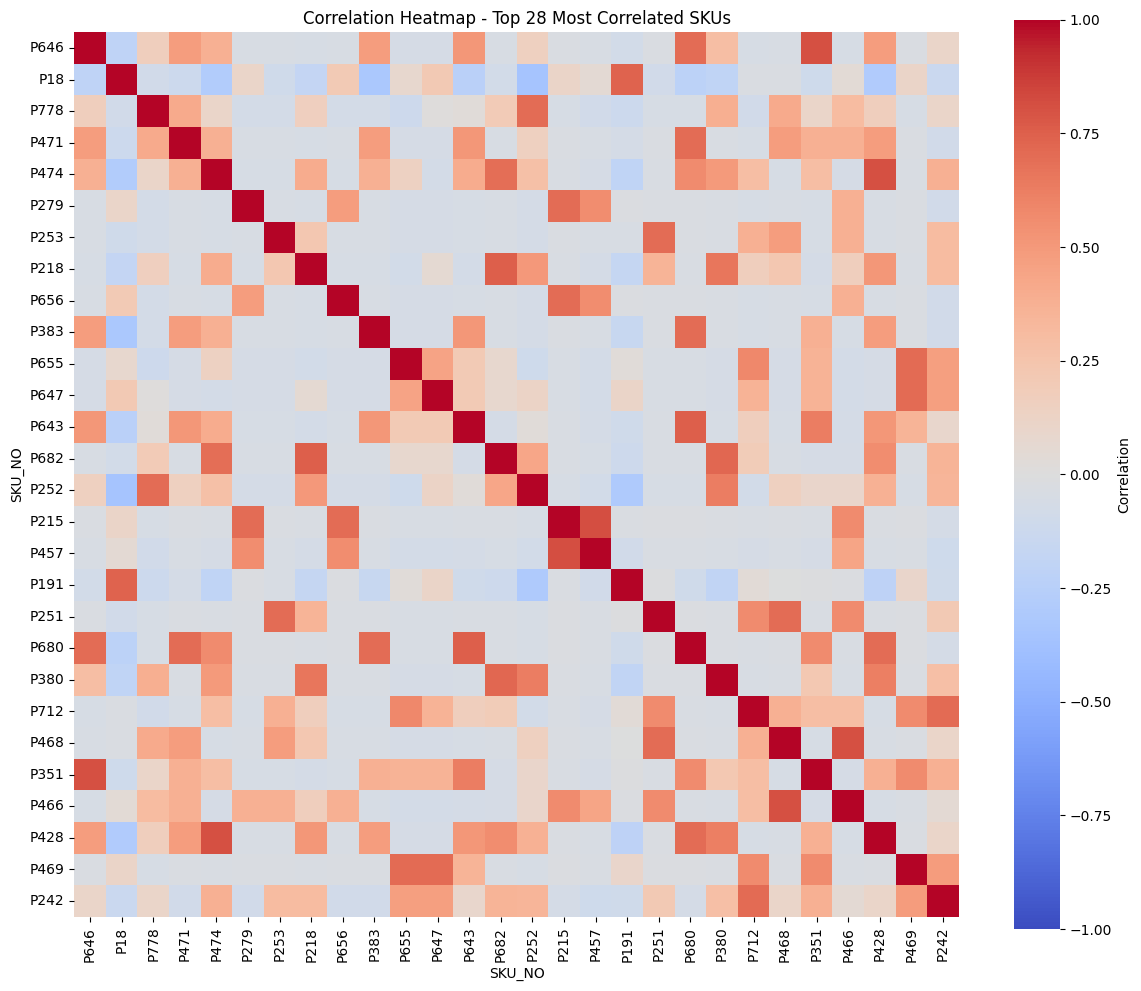

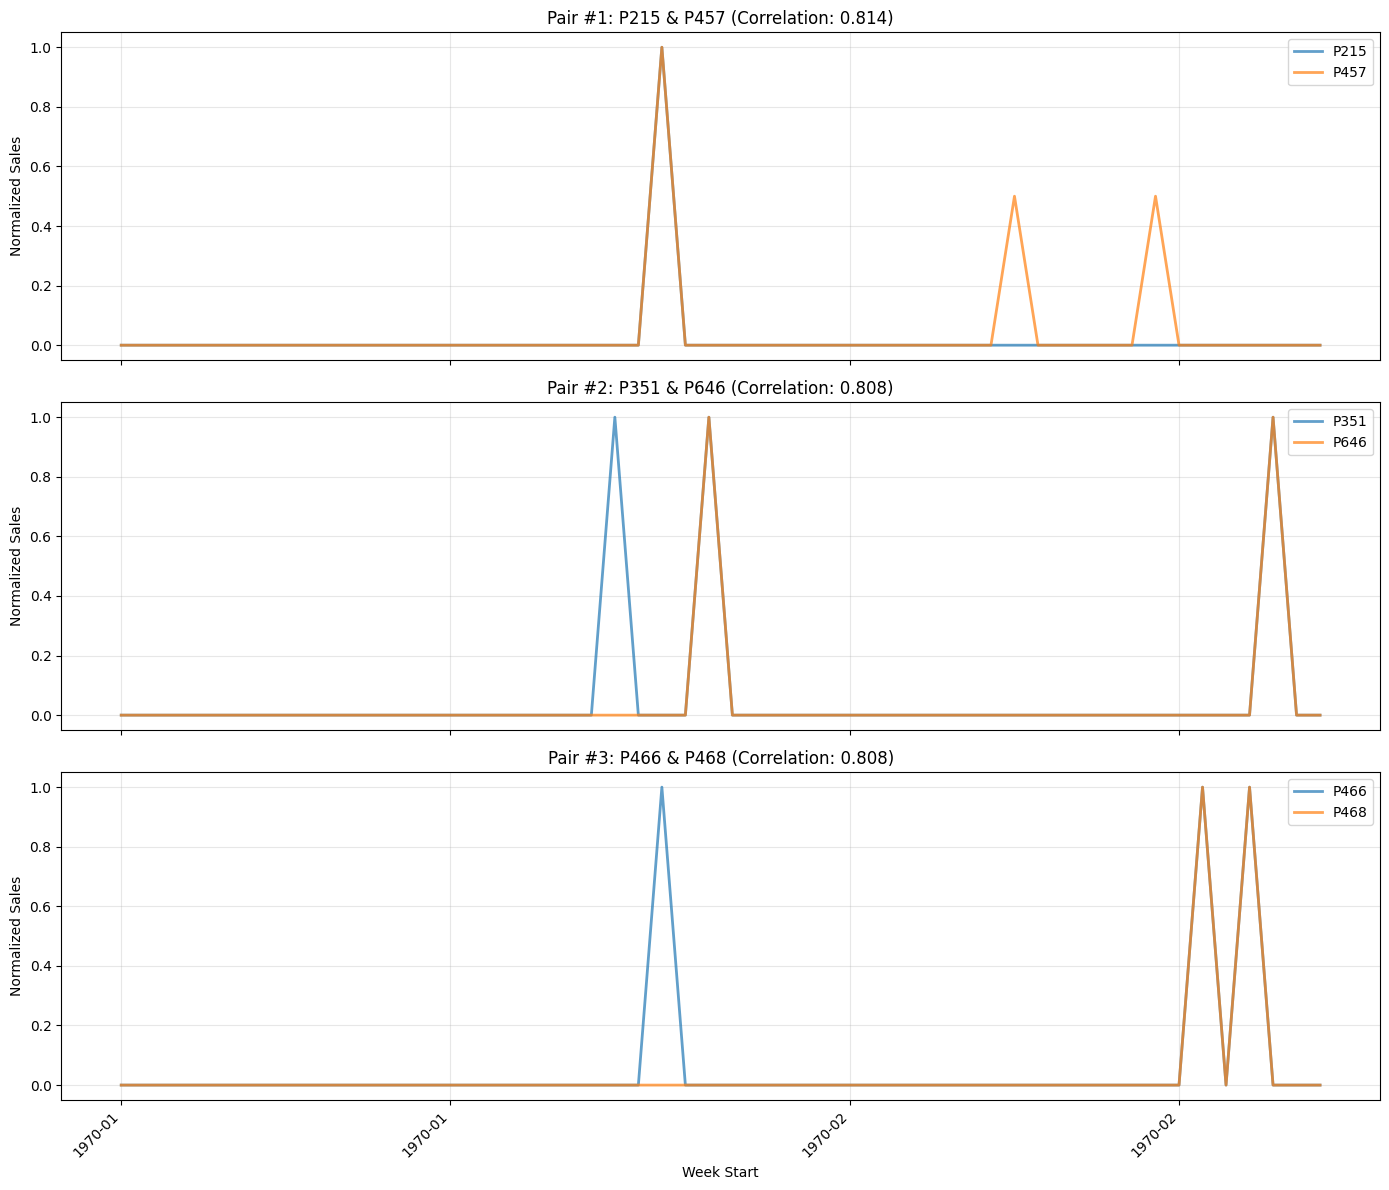


=== Correlation Percentiles ===
1th percentile: -0.317
5th percentile: -0.215
10th percentile: -0.161
25th percentile: -0.072
50th percentile: 0.037
75th percentile: 0.153
90th percentile: 0.261
95th percentile: 0.326
99th percentile: 0.445


In [5]:
# Your existing correlation calculation
wide_df = (
    df
    .pivot(index="week_start", columns="SKU_NO", values="sales")
    .sort_index()
)
corr_matrix = wide_df.corr()

# ============================================
# 1. CORRELATION STATISTICS
# ============================================
# Get upper triangle (exclude diagonal)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
upper_tri_corr = corr_matrix.where(mask)
corr_values = upper_tri_corr.values[mask]

print("\n=== Correlation Statistics ===")
print(f"Number of SKUs: {len(corr_matrix)}")
print(f"Total correlations: {len(corr_values)}")
print(f"Mean correlation: {corr_values.mean():.3f}")
print(f"Median correlation: {np.median(corr_values):.3f}")
print(f"Min correlation: {corr_values.min():.3f}")
print(f"Max correlation: {corr_values.max():.3f}")
print(f"Std correlation: {corr_values.std():.3f}")

# ============================================
# 2. CORRELATION DISTRIBUTION PLOT
# ============================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(corr_values, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(corr_values.mean(), color='red', linestyle='--', 
                label=f'Mean: {corr_values.mean():.3f}')
axes[0].axvline(np.median(corr_values), color='green', linestyle='--', 
                label=f'Median: {np.median(corr_values):.3f}')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Pairwise Correlations')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot with stats
box_data = pd.DataFrame({
    'Correlation': corr_values
})
axes[1].boxplot(corr_values, vert=True)
axes[1].set_ylabel('Correlation')
axes[1].set_title('Correlation Box Plot')
axes[1].grid(alpha=0.3, axis='y')
axes[1].set_xticklabels(['All SKU Pairs'])

plt.tight_layout()
plt.show()

# ============================================
# 3. TOP N MOST CORRELATED PAIRS
# ============================================
def get_top_correlations(corr_matrix, n=20):
    """Extract top N correlated pairs (excluding diagonal)"""
    # Stack and sort
    corr_pairs = (
        corr_matrix
        .where(mask)  # Upper triangle only
        .stack()
        .sort_values(ascending=False)
    )
    return corr_pairs.head(n)

# Get top correlations
n_top = 20
top_corrs = get_top_correlations(corr_matrix, n=n_top)

print(f"\n=== Top {n_top} Most Correlated SKU Pairs ===")
for (sku1, sku2), corr in top_corrs.items():
    print(f"{sku1} <-> {sku2}: {corr:.3f}")

# ============================================
# 4. VISUALIZE TOP CORRELATED PAIRS
# ============================================
fig, ax = plt.subplots(figsize=(12, 6))
pair_labels = [f"{s1}\n{s2}" for s1, s2 in top_corrs.index]
colors = plt.cm.RdYlGn(np.linspace(0.5, 1, len(top_corrs)))

bars = ax.barh(range(len(top_corrs)), top_corrs.values, color=colors)
ax.set_yticks(range(len(top_corrs)))
ax.set_yticklabels(pair_labels, fontsize=8)
ax.set_xlabel('Correlation')
ax.set_title(f'Top {n_top} Most Correlated SKU Pairs')
ax.grid(alpha=0.3, axis='x')
ax.axvline(0, color='black', linewidth=0.8)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_corrs.values)):
    ax.text(val + 0.01, i, f'{val:.3f}', va='center', fontsize=8)

plt.tight_layout()
plt.show()

# ============================================
# 5. HEATMAP FOR TOP N CORRELATED SKUs
# ============================================
# Get unique SKUs from top pairs
top_skus = list(set([sku for pair in top_corrs.index for sku in pair]))
n_heatmap = min(30, len(top_skus))  # Limit to 30 for readability
top_skus = top_skus[:n_heatmap]

print(f"\n=== Creating heatmap for top {len(top_skus)} SKUs ===")

# Subset correlation matrix
subset_corr = corr_matrix.loc[top_skus, top_skus]

plt.figure(figsize=(12, 10))
sns.heatmap(
    subset_corr,
    annot=True if len(top_skus) <= 15 else False,  # Annotate only if small enough
    fmt='.2f' if len(top_skus) <= 15 else None,
    cmap="coolwarm",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5 if len(top_skus) <= 20 else 0,
    cbar_kws={'label': 'Correlation'}
)
plt.title(f'Correlation Heatmap - Top {len(top_skus)} Most Correlated SKUs')
plt.tight_layout()
plt.show()

# ============================================
# 6. TIME SERIES PLOT OF TOP CORRELATED PAIRS
# ============================================
n_plot_pairs = 3
fig, axes = plt.subplots(
    n_plot_pairs, 1,
    figsize=(14, 4 * n_plot_pairs),
    sharex=True
)

if n_plot_pairs == 1:
    axes = [axes]

# Date locator that automatically sparsifies ticks
major_locator = mdates.AutoDateLocator(minticks=5, maxticks=8)
major_formatter = mdates.DateFormatter('%Y-%m')

for idx, ((sku1, sku2), corr) in enumerate(top_corrs.head(n_plot_pairs).items()):
    ax = axes[idx]

    series1 = wide_df[sku1]
    series2 = wide_df[sku2]

    series1_norm = (series1 - series1.min()) / (series1.max() - series1.min())
    series2_norm = (series2 - series2.min()) / (series2.max() - series2.min())

    ax.plot(series1_norm.index, series1_norm, label=sku1, linewidth=2, alpha=0.7)
    ax.plot(series2_norm.index, series2_norm, label=sku2, linewidth=2, alpha=0.7)

    ax.set_title(
        f'Pair #{idx+1}: {sku1} & {sku2} (Correlation: {corr:.3f})'
    )
    ax.set_ylabel('Normalized Sales')
    ax.legend()
    ax.grid(alpha=0.3)

    ax.xaxis.set_major_locator(major_locator)
    ax.xaxis.set_major_formatter(major_formatter)

# rotate only once (shared x-axis)
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45, ha='right')
axes[-1].set_xlabel("Week Start")

plt.tight_layout()
plt.show()

# ============================================
# 7. CORRELATION PERCENTILES
# ============================================
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
print("\n=== Correlation Percentiles ===")
for p in percentiles:
    val = np.percentile(corr_values, p)
    print(f"{p}th percentile: {val:.3f}")

As can be seen, most correlated time series are ones with hight percentage of zero values. Lets filter them out and visulize more interesting examples.

=== Zero Value Analysis ===
Total SKUs: 811

Top 10 sparsest SKUs (% zeros):
SKU_NO
P680    98.1
P684    98.1
P721    98.1
P259    98.1
P254    98.1
P215    98.1
P251    98.1
P469    98.1
P656    96.2
P763    96.2
dtype: float64


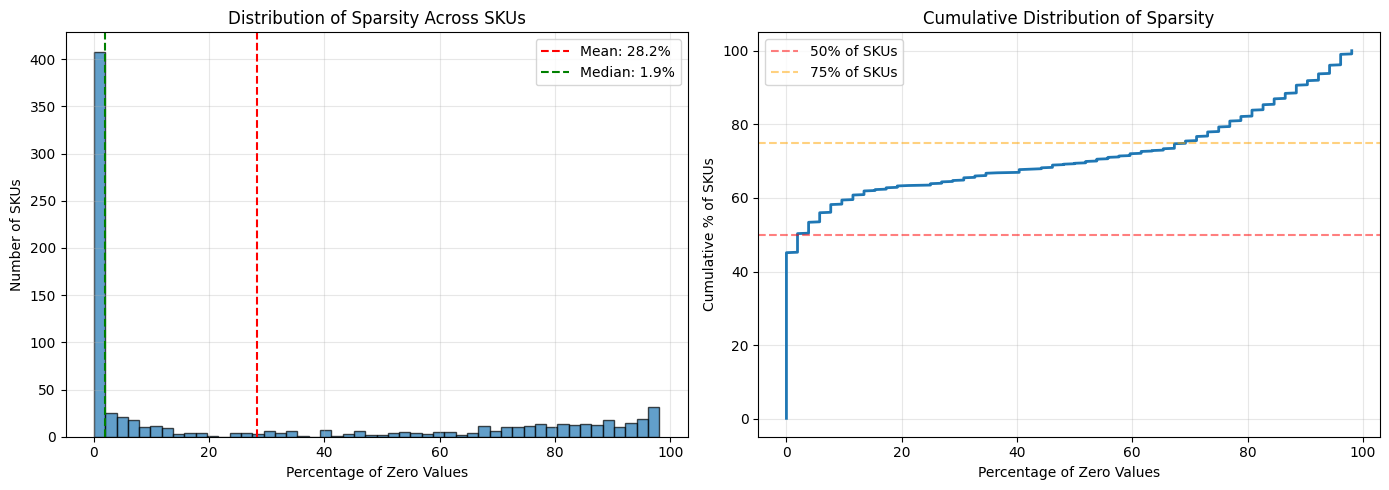


=== Filtering Results ===
Zero threshold: 50%
SKUs remaining: 563 (of 811)
SKUs filtered out: 248

=== Filtered Correlation Statistics ===
Mean correlation: 0.074
Median correlation: 0.074
Min correlation: -0.640
Max correlation: 0.738

=== Comparison: Before vs After Filtering ===
Metric               Original        Filtered        Change
-----------------------------------------------------------------
Mean correlation     0.044           0.074           +0.030
Median correlation   0.037           0.074           +0.037
Max correlation      0.814           0.738           -0.076

=== Top 20 Most Correlated SKU Pairs (After Filtering) ===
P18 <-> P191: 0.738 (zeros: 0.0%, 0.0%)
P208 <-> P409: 0.685 (zeros: 0.0%, 0.0%)
P263 <-> P526: 0.677 (zeros: 0.0%, 0.0%)
P399 <-> P404: 0.674 (zeros: 0.0%, 0.0%)
P406 <-> P512: 0.673 (zeros: 0.0%, 0.0%)
P410 <-> P526: 0.670 (zeros: 0.0%, 0.0%)
P405 <-> P409: 0.663 (zeros: 0.0%, 0.0%)
P507 <-> P535: 0.663 (zeros: 0.0%, 0.0%)
P409 <-> P512: 0.662 (z

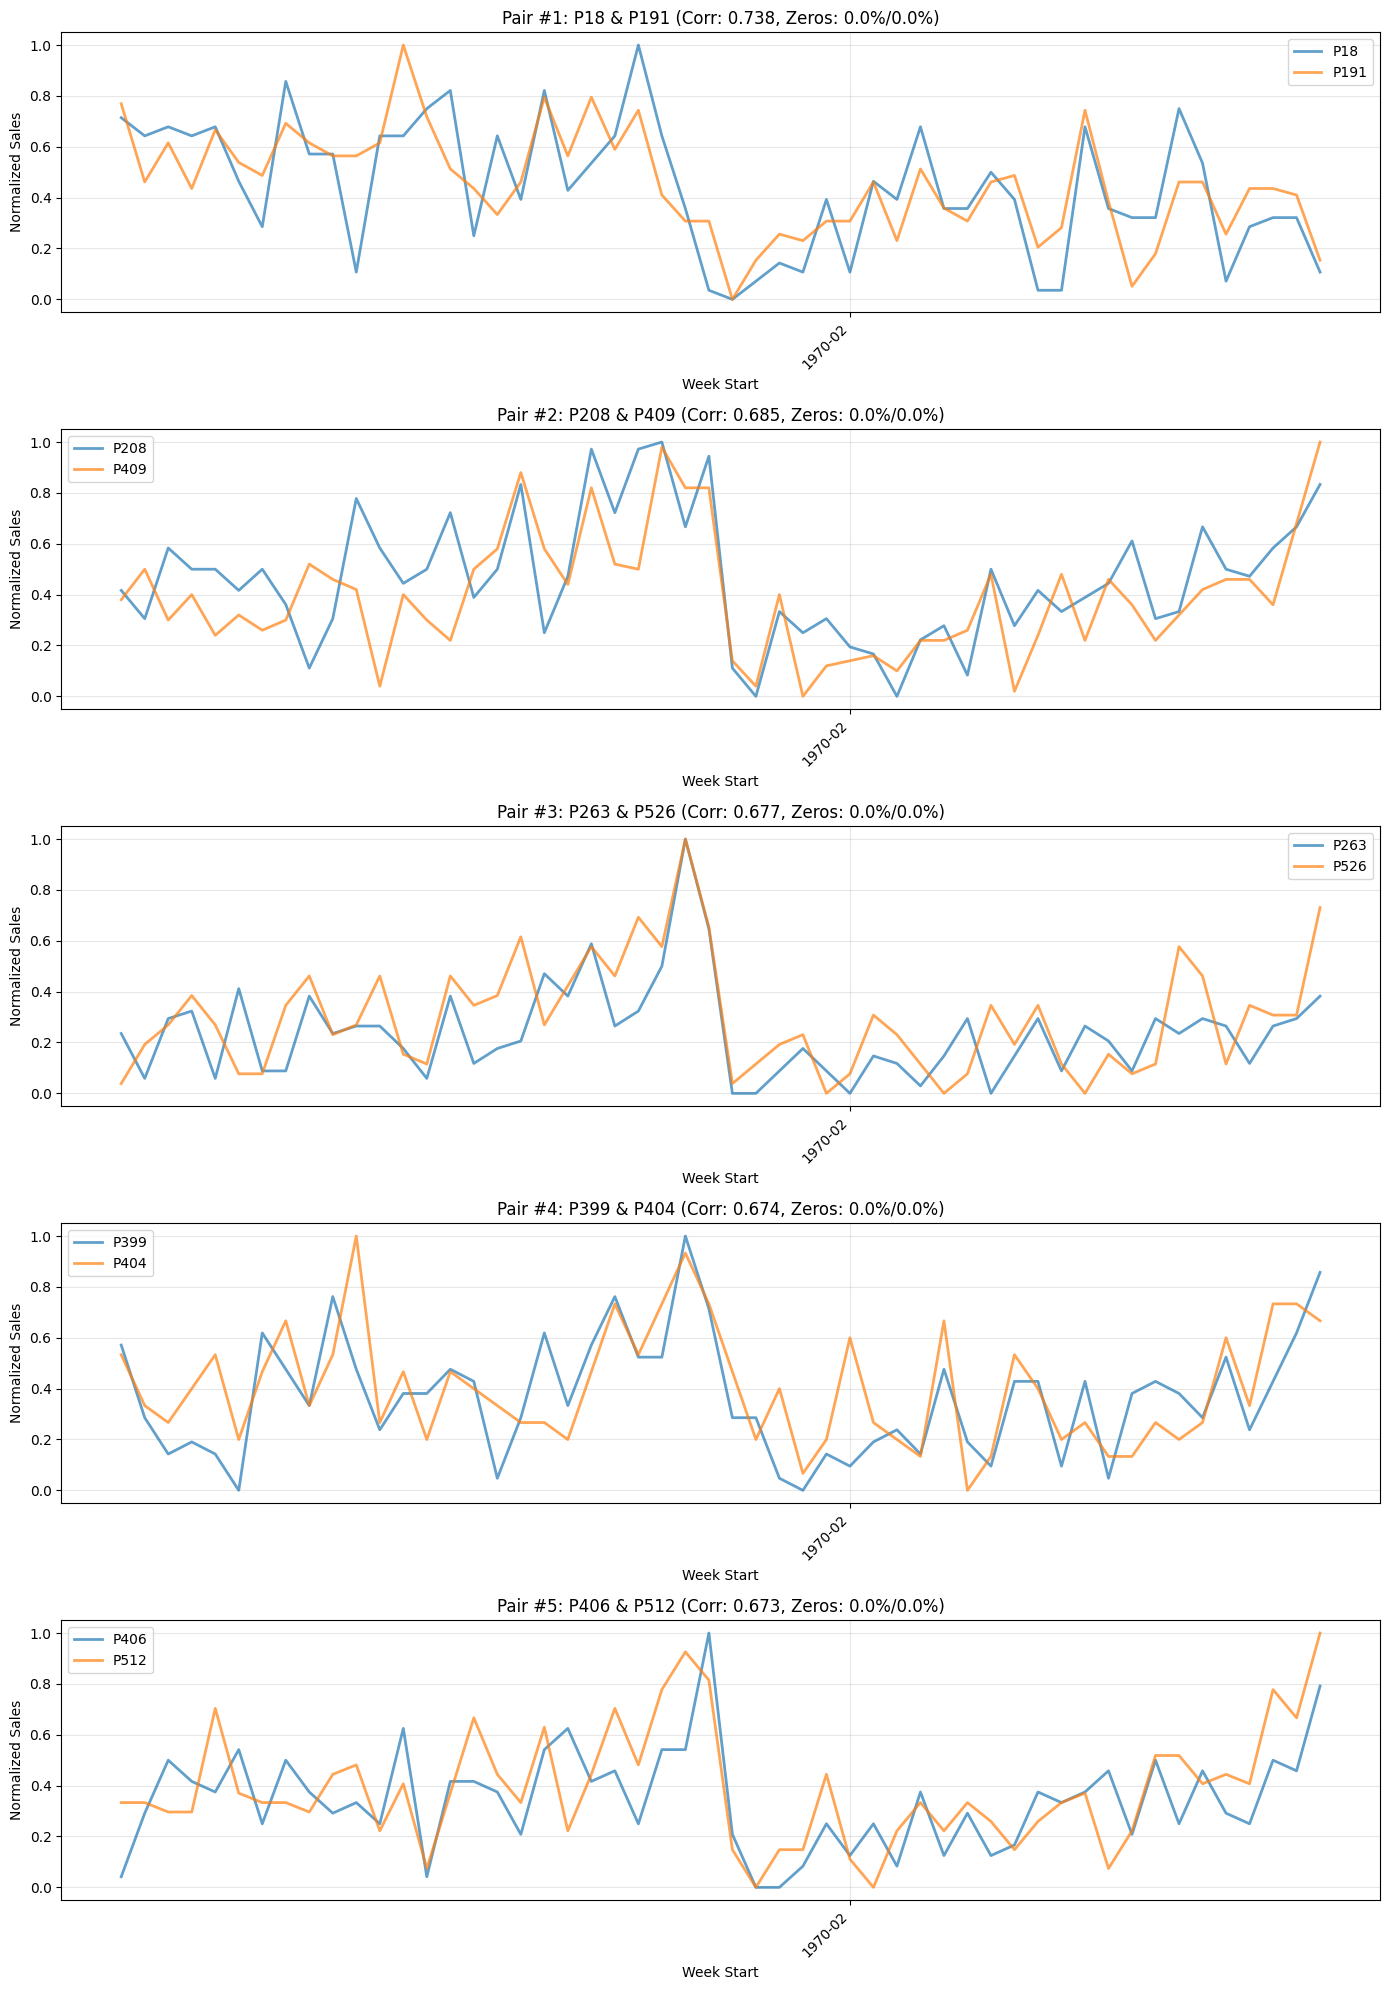

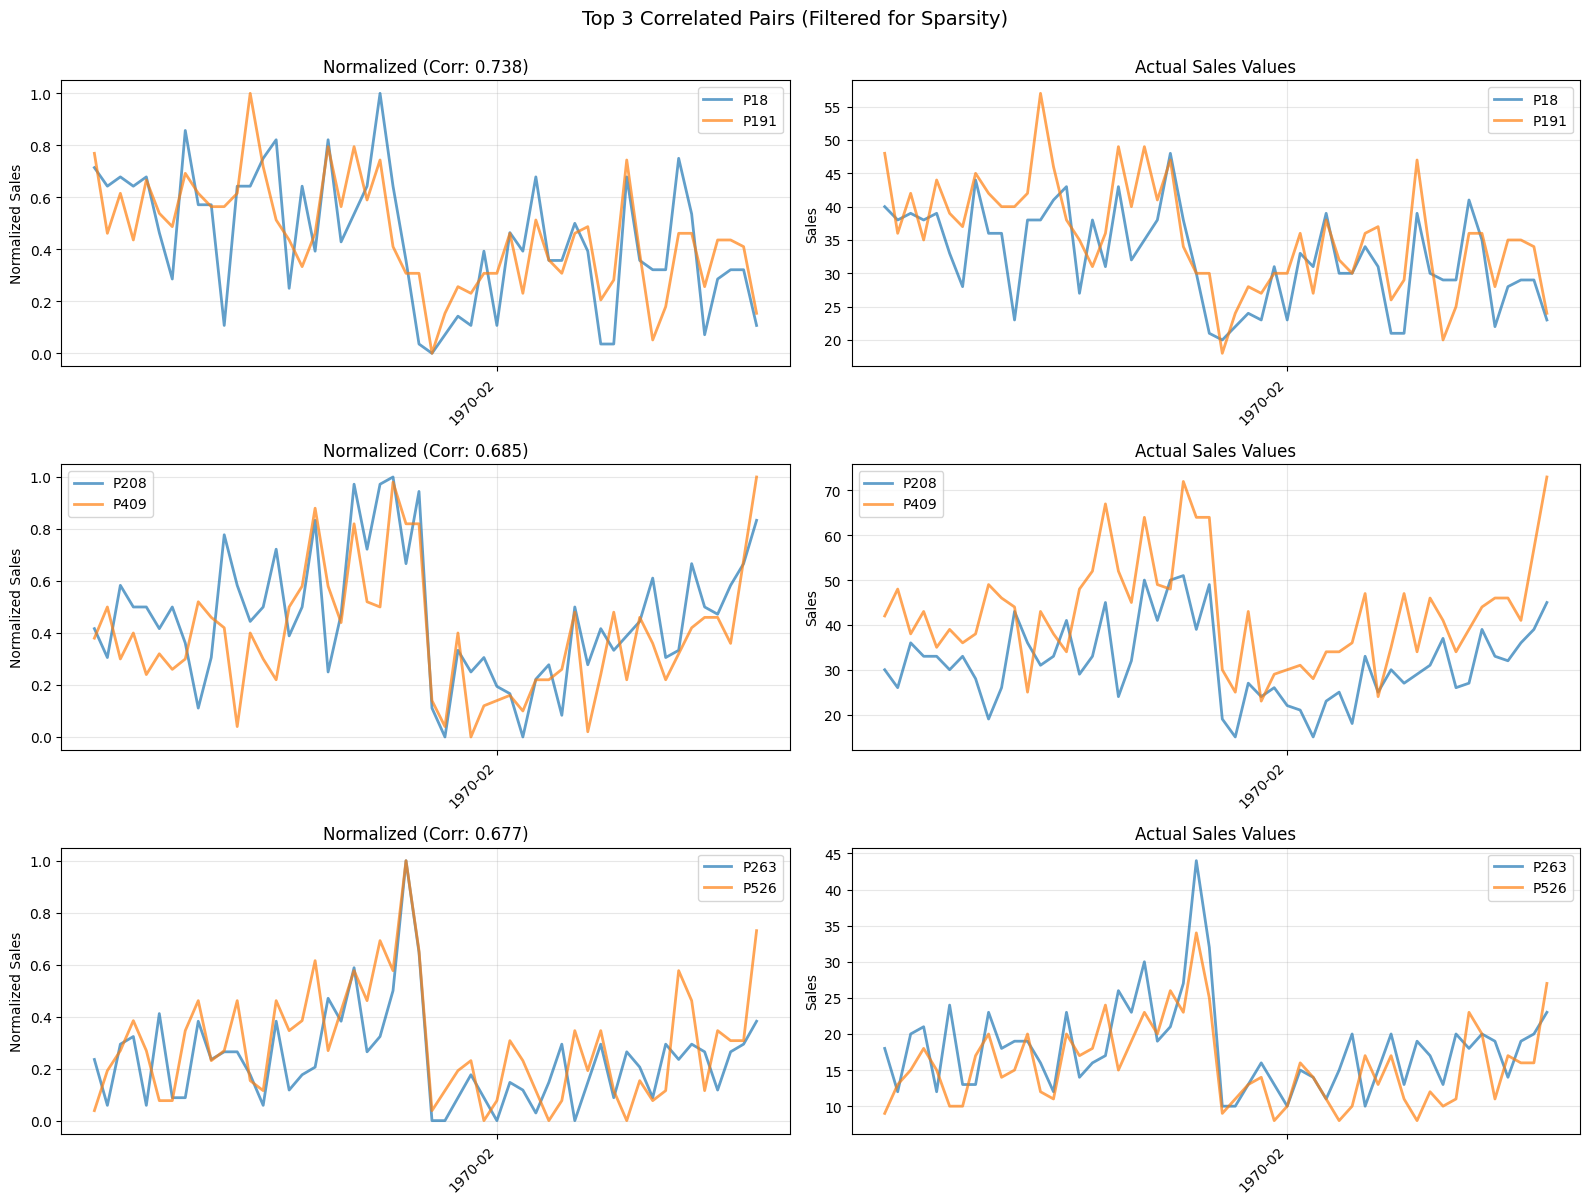


✓ Analysis complete! These correlations represent genuine co-movement patterns.


In [6]:
# ============================================
# FILTER OUT SPARSE TIME SERIES
# ============================================

# Calculate percentage of zero values for each SKU
zero_pct = (wide_df == 0).sum() / len(wide_df) * 100
zero_pct_sorted = zero_pct.sort_values(ascending=False)

print("=== Zero Value Analysis ===")
print(f"Total SKUs: {len(zero_pct)}")
print(f"\nTop 10 sparsest SKUs (% zeros):")
print(zero_pct_sorted.head(10).round(1))

# Plot distribution of zero percentages
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(zero_pct, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(zero_pct.mean(), color='red', linestyle='--', 
                label=f'Mean: {zero_pct.mean():.1f}%')
axes[0].axvline(zero_pct.median(), color='green', linestyle='--', 
                label=f'Median: {zero_pct.median():.1f}%')
axes[0].set_xlabel('Percentage of Zero Values')
axes[0].set_ylabel('Number of SKUs')
axes[0].set_title('Distribution of Sparsity Across SKUs')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Cumulative distribution
sorted_zero_pct = np.sort(zero_pct)
cumulative = np.arange(1, len(sorted_zero_pct) + 1) / len(sorted_zero_pct) * 100
axes[1].plot(sorted_zero_pct, cumulative, linewidth=2)
axes[1].axhline(50, color='red', linestyle='--', alpha=0.5, label='50% of SKUs')
axes[1].axhline(75, color='orange', linestyle='--', alpha=0.5, label='75% of SKUs')
axes[1].set_xlabel('Percentage of Zero Values')
axes[1].set_ylabel('Cumulative % of SKUs')
axes[1].set_title('Cumulative Distribution of Sparsity')
axes[1].grid(alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# ============================================
# FILTER AND RECALCULATE CORRELATIONS
# ============================================

# Set threshold for filtering (adjust as needed)
zero_threshold = 50  # Filter out SKUs with >50% zeros

dense_skus = zero_pct[zero_pct <= zero_threshold].index
print(f"\n=== Filtering Results ===")
print(f"Zero threshold: {zero_threshold}%")
print(f"SKUs remaining: {len(dense_skus)} (of {len(zero_pct)})")
print(f"SKUs filtered out: {len(zero_pct) - len(dense_skus)}")

# Create filtered dataframe
wide_df_filtered = wide_df[dense_skus]

# Recalculate correlations
corr_matrix_filtered = wide_df_filtered.corr()

# Get correlation statistics
mask_filtered = np.triu(np.ones_like(corr_matrix_filtered, dtype=bool), k=1)
upper_tri_corr_filtered = corr_matrix_filtered.where(mask_filtered)
corr_values_filtered = upper_tri_corr_filtered.values[mask_filtered]

print("\n=== Filtered Correlation Statistics ===")
print(f"Mean correlation: {corr_values_filtered.mean():.3f}")
print(f"Median correlation: {np.median(corr_values_filtered):.3f}")
print(f"Min correlation: {corr_values_filtered.min():.3f}")
print(f"Max correlation: {corr_values_filtered.max():.3f}")

# Compare before/after
print("\n=== Comparison: Before vs After Filtering ===")
print(f"{'Metric':<20} {'Original':<15} {'Filtered':<15} {'Change'}")
print(f"{'-'*65}")
print(f"{'Mean correlation':<20} {corr_values.mean():<15.3f} {corr_values_filtered.mean():<15.3f} {corr_values_filtered.mean() - corr_values.mean():+.3f}")
print(f"{'Median correlation':<20} {np.median(corr_values):<15.3f} {np.median(corr_values_filtered):<15.3f} {np.median(corr_values_filtered) - np.median(corr_values):+.3f}")
print(f"{'Max correlation':<20} {corr_values.max():<15.3f} {corr_values_filtered.max():<15.3f} {corr_values_filtered.max() - corr_values.max():+.3f}")

# ============================================
# TOP CORRELATED PAIRS (FILTERED)
# ============================================

def get_top_correlations(corr_matrix, n=20):
    """Extract top N correlated pairs (excluding diagonal)"""
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_pairs = (
        corr_matrix
        .where(mask)
        .stack()
        .sort_values(ascending=False)
    )
    return corr_pairs.head(n)

n_top = 20
top_corrs_filtered = get_top_correlations(corr_matrix_filtered, n=n_top)

print(f"\n=== Top {n_top} Most Correlated SKU Pairs (After Filtering) ===")
for (sku1, sku2), corr in top_corrs_filtered.items():
    zero_pct1 = zero_pct[sku1]
    zero_pct2 = zero_pct[sku2]
    print(f"{sku1} <-> {sku2}: {corr:.3f} (zeros: {zero_pct1:.1f}%, {zero_pct2:.1f}%)")

# ============================================
# VISUALIZE FILTERED TOP CORRELATED PAIRS
# ============================================

n_plot_pairs = 5
fig, axes = plt.subplots(n_plot_pairs, 1, figsize=(14, 4*n_plot_pairs))
if n_plot_pairs == 1:
    axes = [axes]

for idx, ((sku1, sku2), corr) in enumerate(top_corrs_filtered.head(n_plot_pairs).items()):
    ax = axes[idx]
    
    # Get original series
    series1 = wide_df_filtered[sku1]
    series2 = wide_df_filtered[sku2]
    
    # Normalize to 0-1 for better comparison
    series1_norm = (series1 - series1.min()) / (series1.max() - series1.min())
    series2_norm = (series2 - series2.min()) / (series2.max() - series2.min())
    
    # Plot
    ax.plot(series1_norm.index, series1_norm, label=f'{sku1}', linewidth=2, alpha=0.7)
    ax.plot(series2_norm.index, series2_norm, label=f'{sku2}', linewidth=2, alpha=0.7)
    
    # Add zero percentage info to title
    zero_pct1 = zero_pct[sku1]
    zero_pct2 = zero_pct[sku2]
    ax.set_title(f'Pair #{idx+1}: {sku1} & {sku2} (Corr: {corr:.3f}, Zeros: {zero_pct1:.1f}%/{zero_pct2:.1f}%)')
    ax.set_xlabel('Week Start')
    ax.set_ylabel('Normalized Sales')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # Fix date formatting
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# ============================================
# SIDE-BY-SIDE COMPARISON: ACTUAL VALUES
# ============================================

# Plot actual (non-normalized) values for top 3 pairs
n_plot_pairs = 3
fig, axes = plt.subplots(n_plot_pairs, 2, figsize=(16, 4*n_plot_pairs))

for idx, ((sku1, sku2), corr) in enumerate(top_corrs_filtered.head(n_plot_pairs).items()):
    # Normalized plot (left)
    ax_norm = axes[idx, 0]
    series1 = wide_df_filtered[sku1]
    series2 = wide_df_filtered[sku2]
    series1_norm = (series1 - series1.min()) / (series1.max() - series1.min())
    series2_norm = (series2 - series2.min()) / (series2.max() - series2.min())
    
    ax_norm.plot(series1_norm.index, series1_norm, label=f'{sku1}', linewidth=2, alpha=0.7)
    ax_norm.plot(series2_norm.index, series2_norm, label=f'{sku2}', linewidth=2, alpha=0.7)
    ax_norm.set_title(f'Normalized (Corr: {corr:.3f})')
    ax_norm.set_ylabel('Normalized Sales')
    ax_norm.legend()
    ax_norm.grid(alpha=0.3)
    ax_norm.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax_norm.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax_norm.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    # Actual values plot (right)
    ax_actual = axes[idx, 1]
    ax_actual.plot(series1.index, series1, label=f'{sku1}', linewidth=2, alpha=0.7)
    ax_actual.plot(series2.index, series2, label=f'{sku2}', linewidth=2, alpha=0.7)
    ax_actual.set_title(f'Actual Sales Values')
    ax_actual.set_ylabel('Sales')
    ax_actual.legend()
    ax_actual.grid(alpha=0.3)
    ax_actual.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax_actual.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax_actual.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.suptitle(f'Top {n_plot_pairs} Correlated Pairs (Filtered for Sparsity)', 
             fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\n✓ Analysis complete! These correlations represent genuine co-movement patterns.")

=== Correlation Pattern Analysis (Filtered Data) ===

Total correlation values: 158203
Positive correlations: 105609 (66.8%)
Negative correlations: 52592 (33.2%)
Near-zero correlations (|r| < 0.1): 64379 (40.7%)

=== Top 10 MOST POSITIVELY Correlated Pairs ===
P18 <-> P191: +0.738
P208 <-> P409: +0.685
P263 <-> P526: +0.677
P399 <-> P404: +0.674
P406 <-> P512: +0.673
P410 <-> P526: +0.670
P405 <-> P409: +0.663
P507 <-> P535: +0.663
P409 <-> P512: +0.662
P262 <-> P512: +0.662

=== Top 10 MOST NEGATIVELY Correlated Pairs ===
P46 <-> P599: -0.640
P373 <-> P42: -0.612
P51 <-> P693: -0.568
P670 <-> P78: -0.564
P78 <-> P816: -0.543
P176 <-> P703: -0.538
P64 <-> P675: -0.533
P373 <-> P44: -0.527
P149 <-> P703: -0.527
P599 <-> P76: -0.526

=== Top 10 NEAR-ZERO Correlated Pairs (No Relationship) ===
P641 <-> P786: +0.000
P113 <-> P325: +0.000
P412 <-> P563: +0.000
P303 <-> P704: -0.000
P499 <-> P699: -0.000
P432 <-> P641: +0.000
P319 <-> P641: -0.000
P127 <-> P6: +0.000
P288 <-> P641: -0.000
P1

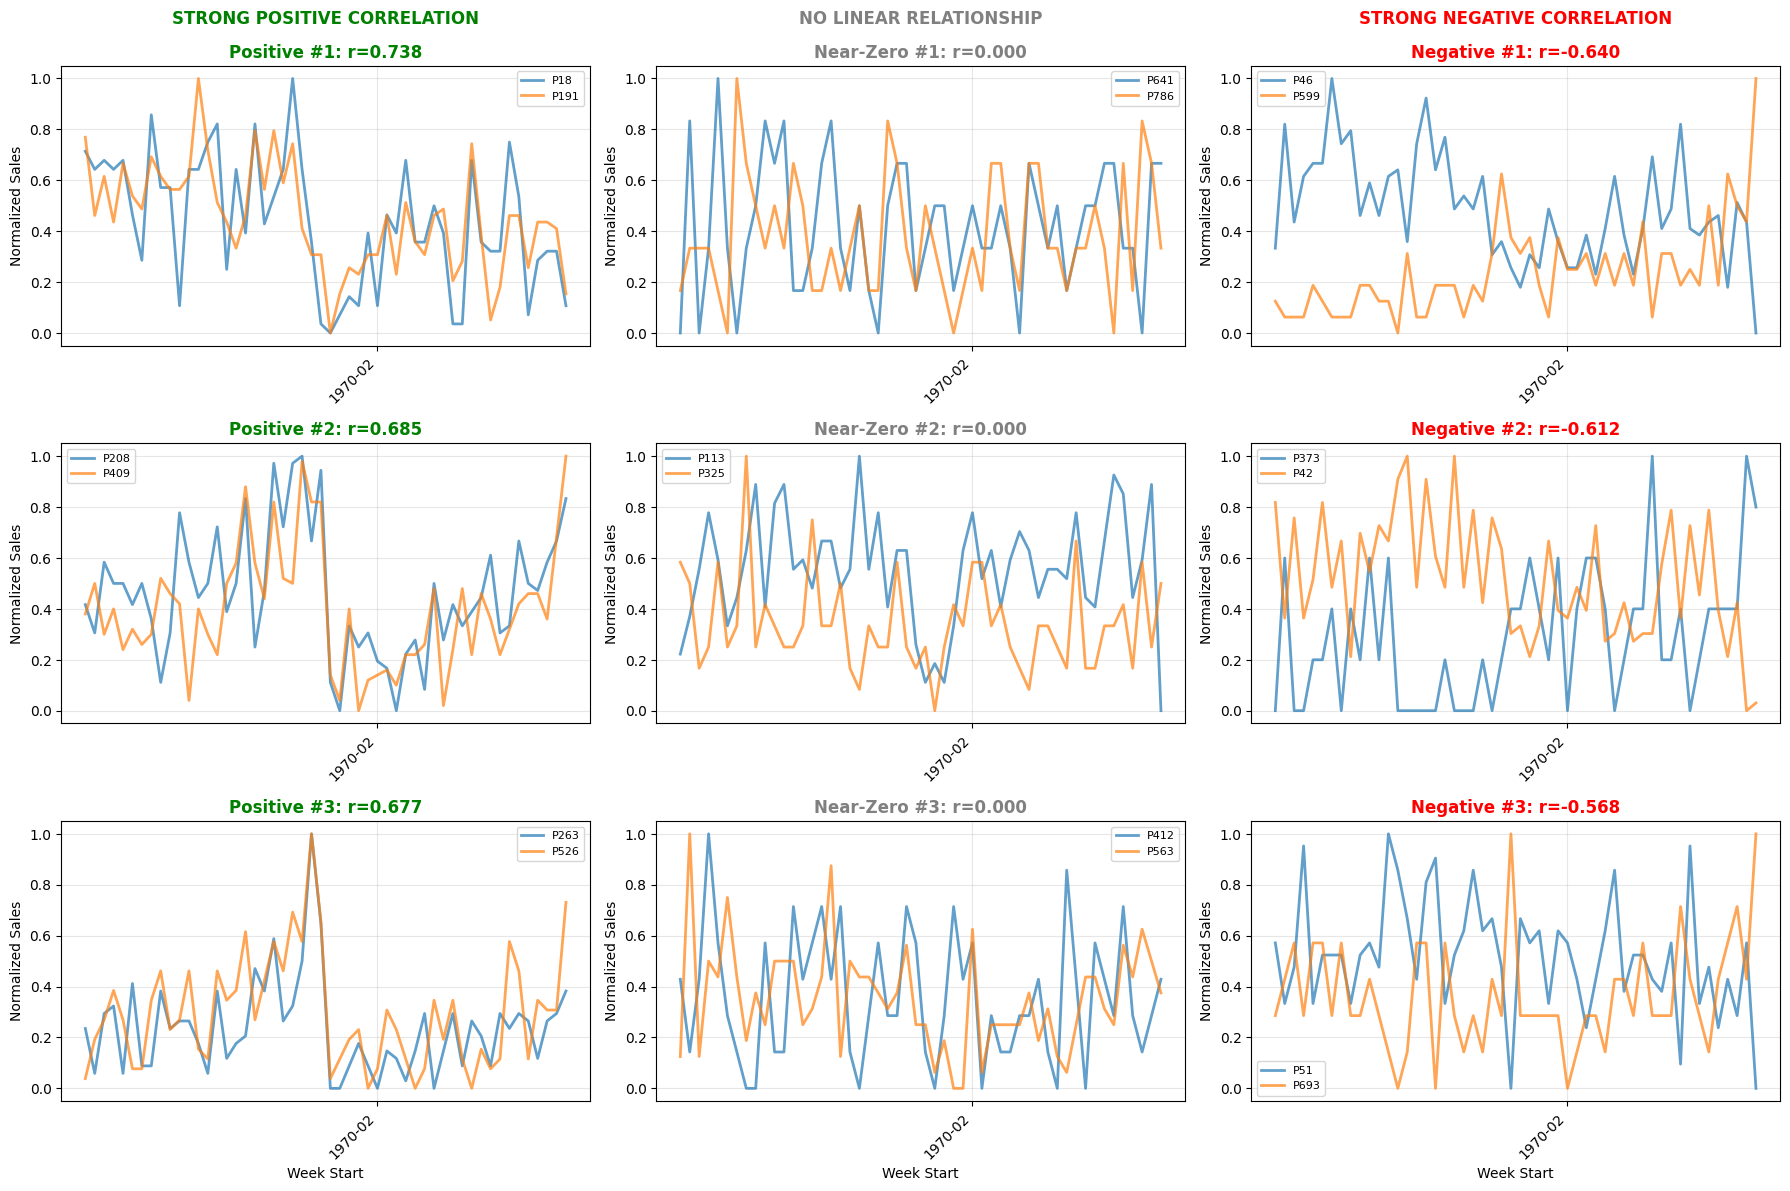

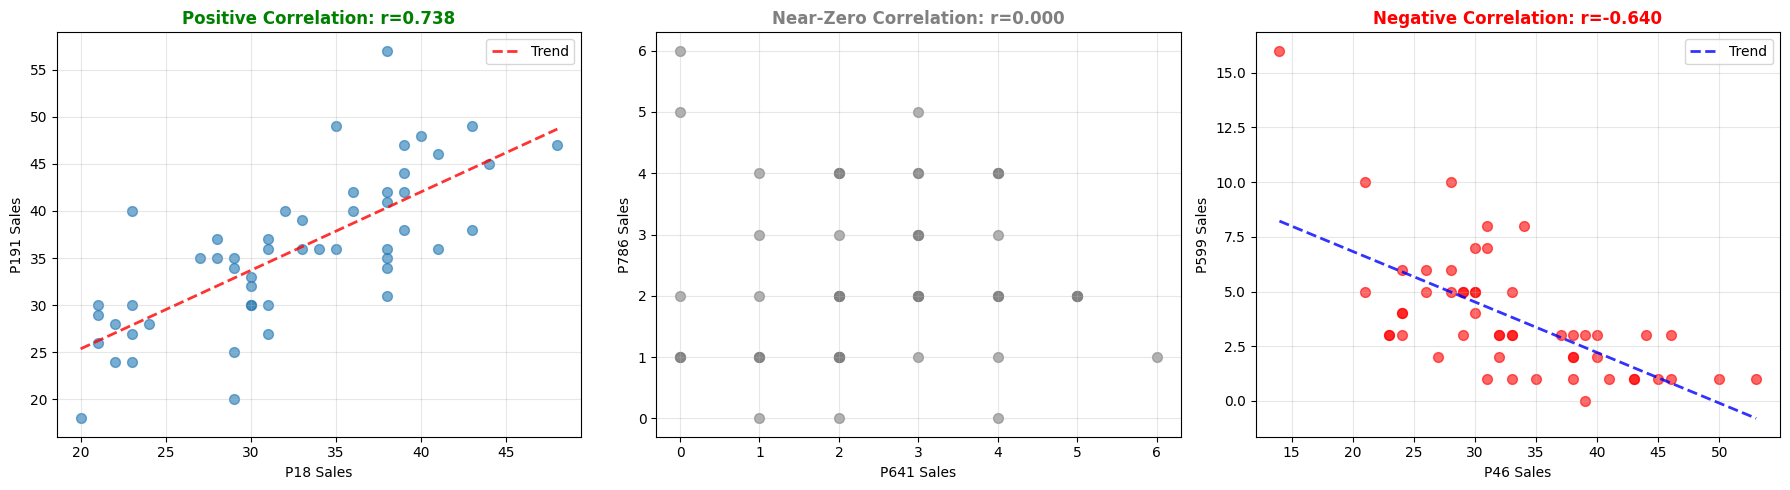


=== Interpretation Guide ===

📈 POSITIVE CORRELATION (r > 0.5):
   - Products move together
   - Could indicate: substitutes, complementary products, seasonal patterns
   - Useful for: bundling, joint promotions, inventory planning

➡️ NEAR-ZERO CORRELATION (|r| < 0.1):
   - Products have independent demand
   - Could indicate: different customer segments, different use cases
   - Useful for: diversification, independent forecasting

📉 NEGATIVE CORRELATION (r < -0.3):
   - Products move in opposite directions
   - Could indicate: competing products, substitution effects, seasonal shifts
   - Useful for: portfolio balancing, understanding cannibalization

=== Correlation Distribution ===
Strong positive (r > 0.7): 1 pairs (0.0%)
Moderate positive (0.3 < r < 0.7): 14818 pairs (9.4%)
Weak/No correlation (|r| < 0.3): 141139 pairs (89.2%)
Moderate negative (-0.7 < r < -0.3): 2245 pairs (1.4%)
Strong negative (r < -0.7): 0 pairs (0.0%)


In [7]:
# ============================================
# ANALYZE DIFFERENT CORRELATION PATTERNS
# ============================================

print("=== Correlation Pattern Analysis (Filtered Data) ===")
print(f"\nTotal correlation values: {len(corr_values_filtered)}")
print(f"Positive correlations: {(corr_values_filtered > 0).sum()} ({(corr_values_filtered > 0).sum() / len(corr_values_filtered) * 100:.1f}%)")
print(f"Negative correlations: {(corr_values_filtered < 0).sum()} ({(corr_values_filtered < 0).sum() / len(corr_values_filtered) * 100:.1f}%)")
print(f"Near-zero correlations (|r| < 0.1): {(np.abs(corr_values_filtered) < 0.1).sum()} ({(np.abs(corr_values_filtered) < 0.1).sum() / len(corr_values_filtered) * 100:.1f}%)")

# ============================================
# EXTRACT DIFFERENT CORRELATION TYPES
# ============================================

def get_correlations_by_type(corr_matrix, corr_type='positive', n=10):
    """
    Extract correlations by type
    corr_type: 'positive', 'negative', 'near_zero'
    """
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    corr_pairs = corr_matrix.where(mask).stack()
    
    if corr_type == 'positive':
        return corr_pairs.sort_values(ascending=False).head(n)
    elif corr_type == 'negative':
        return corr_pairs.sort_values(ascending=True).head(n)
    elif corr_type == 'near_zero':
        # Find correlations closest to zero
        abs_corr = corr_pairs.abs()
        return corr_pairs[abs_corr.sort_values().index].head(n)
    
n_show = 10

# Get different correlation types
top_positive = get_correlations_by_type(corr_matrix_filtered, 'positive', n_show)
top_negative = get_correlations_by_type(corr_matrix_filtered, 'negative', n_show)
near_zero = get_correlations_by_type(corr_matrix_filtered, 'near_zero', n_show)

print(f"\n=== Top {n_show} MOST POSITIVELY Correlated Pairs ===")
for (sku1, sku2), corr in top_positive.items():
    print(f"{sku1} <-> {sku2}: {corr:+.3f}")

print(f"\n=== Top {n_show} MOST NEGATIVELY Correlated Pairs ===")
for (sku1, sku2), corr in top_negative.items():
    print(f"{sku1} <-> {sku2}: {corr:+.3f}")

print(f"\n=== Top {n_show} NEAR-ZERO Correlated Pairs (No Relationship) ===")
for (sku1, sku2), corr in near_zero.items():
    print(f"{sku1} <-> {sku2}: {corr:+.3f}")

# ============================================
# VISUALIZE ALL THREE TYPES
# ============================================

n_pairs_per_type = 3

fig, axes = plt.subplots(n_pairs_per_type, 3, figsize=(18, 4*n_pairs_per_type))

# Column 1: Positive correlations
for idx, ((sku1, sku2), corr) in enumerate(top_positive.head(n_pairs_per_type).items()):
    ax = axes[idx, 0]
    
    series1 = wide_df_filtered[sku1]
    series2 = wide_df_filtered[sku2]
    series1_norm = (series1 - series1.min()) / (series1.max() - series1.min())
    series2_norm = (series2 - series2.min()) / (series2.max() - series2.min())
    
    ax.plot(series1_norm.index, series1_norm, label=f'{sku1}', linewidth=2, alpha=0.7)
    ax.plot(series2_norm.index, series2_norm, label=f'{sku2}', linewidth=2, alpha=0.7)
    ax.set_title(f'Positive #{idx+1}: r={corr:.3f}', fontweight='bold', color='green')
    ax.set_ylabel('Normalized Sales')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    if idx == 0:
        ax.text(0.5, 1.15, 'STRONG POSITIVE CORRELATION', 
                transform=ax.transAxes, ha='center', fontsize=12, 
                fontweight='bold', color='green')

# Column 2: Near-zero correlations
for idx, ((sku1, sku2), corr) in enumerate(near_zero.head(n_pairs_per_type).items()):
    ax = axes[idx, 1]
    
    series1 = wide_df_filtered[sku1]
    series2 = wide_df_filtered[sku2]
    series1_norm = (series1 - series1.min()) / (series1.max() - series1.min())
    series2_norm = (series2 - series2.min()) / (series2.max() - series2.min())
    
    ax.plot(series1_norm.index, series1_norm, label=f'{sku1}', linewidth=2, alpha=0.7)
    ax.plot(series2_norm.index, series2_norm, label=f'{sku2}', linewidth=2, alpha=0.7)
    ax.set_title(f'Near-Zero #{idx+1}: r={corr:.3f}', fontweight='bold', color='gray')
    ax.set_ylabel('Normalized Sales')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    if idx == 0:
        ax.text(0.5, 1.15, 'NO LINEAR RELATIONSHIP', 
                transform=ax.transAxes, ha='center', fontsize=12, 
                fontweight='bold', color='gray')

# Column 3: Negative correlations
for idx, ((sku1, sku2), corr) in enumerate(top_negative.head(n_pairs_per_type).items()):
    ax = axes[idx, 2]
    
    series1 = wide_df_filtered[sku1]
    series2 = wide_df_filtered[sku2]
    series1_norm = (series1 - series1.min()) / (series1.max() - series1.min())
    series2_norm = (series2 - series2.min()) / (series2.max() - series2.min())
    
    ax.plot(series1_norm.index, series1_norm, label=f'{sku1}', linewidth=2, alpha=0.7)
    ax.plot(series2_norm.index, series2_norm, label=f'{sku2}', linewidth=2, alpha=0.7)
    ax.set_title(f'Negative #{idx+1}: r={corr:.3f}', fontweight='bold', color='red')
    ax.set_ylabel('Normalized Sales')
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    if idx == 0:
        ax.text(0.5, 1.15, 'STRONG NEGATIVE CORRELATION', 
                transform=ax.transAxes, ha='center', fontsize=12, 
                fontweight='bold', color='red')

# Add x-label to bottom row
for ax in axes[-1, :]:
    ax.set_xlabel('Week Start')

plt.tight_layout()
plt.show()

# ============================================
# SCATTER PLOTS: Direct Comparison
# ============================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Positive correlation scatter
sku1, sku2 = top_positive.index[0]
corr = top_positive.iloc[0]
ax = axes[0]
ax.scatter(wide_df_filtered[sku1], wide_df_filtered[sku2], alpha=0.6, s=50)
ax.set_xlabel(f'{sku1} Sales')
ax.set_ylabel(f'{sku2} Sales')
ax.set_title(f'Positive Correlation: r={corr:.3f}', fontweight='bold', color='green')
ax.grid(alpha=0.3)

# Add trend line
z = np.polyfit(wide_df_filtered[sku1].dropna(), wide_df_filtered[sku2].dropna(), 1)
p = np.poly1d(z)
x_trend = np.linspace(wide_df_filtered[sku1].min(), wide_df_filtered[sku1].max(), 100)
ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

# Near-zero correlation scatter
sku1, sku2 = near_zero.index[0]
corr = near_zero.iloc[0]
ax = axes[1]
ax.scatter(wide_df_filtered[sku1], wide_df_filtered[sku2], alpha=0.6, s=50, color='gray')
ax.set_xlabel(f'{sku1} Sales')
ax.set_ylabel(f'{sku2} Sales')
ax.set_title(f'Near-Zero Correlation: r={corr:.3f}', fontweight='bold', color='gray')
ax.grid(alpha=0.3)

# Negative correlation scatter
sku1, sku2 = top_negative.index[0]
corr = top_negative.iloc[0]
ax = axes[2]
ax.scatter(wide_df_filtered[sku1], wide_df_filtered[sku2], alpha=0.6, s=50, color='red')
ax.set_xlabel(f'{sku1} Sales')
ax.set_ylabel(f'{sku2} Sales')
ax.set_title(f'Negative Correlation: r={corr:.3f}', fontweight='bold', color='red')
ax.grid(alpha=0.3)

# Add trend line
z = np.polyfit(wide_df_filtered[sku1].dropna(), wide_df_filtered[sku2].dropna(), 1)
p = np.poly1d(z)
x_trend = np.linspace(wide_df_filtered[sku1].min(), wide_df_filtered[sku1].max(), 100)
ax.plot(x_trend, p(x_trend), "b--", alpha=0.8, linewidth=2, label='Trend')
ax.legend()

plt.tight_layout()
plt.show()

# ============================================
# SUMMARY STATISTICS BY TYPE
# ============================================

print("\n=== Interpretation Guide ===")
print("\n📈 POSITIVE CORRELATION (r > 0.5):")
print("   - Products move together")
print("   - Could indicate: substitutes, complementary products, seasonal patterns")
print("   - Useful for: bundling, joint promotions, inventory planning")

print("\n➡️ NEAR-ZERO CORRELATION (|r| < 0.1):")
print("   - Products have independent demand")
print("   - Could indicate: different customer segments, different use cases")
print("   - Useful for: diversification, independent forecasting")

print("\n📉 NEGATIVE CORRELATION (r < -0.3):")
print("   - Products move in opposite directions")
print("   - Could indicate: competing products, substitution effects, seasonal shifts")
print("   - Useful for: portfolio balancing, understanding cannibalization")

# Distribution breakdown
print("\n=== Correlation Distribution ===")
print(f"Strong positive (r > 0.7): {(corr_values_filtered > 0.7).sum()} pairs ({(corr_values_filtered > 0.7).sum() / len(corr_values_filtered) * 100:.1f}%)")
print(f"Moderate positive (0.3 < r < 0.7): {((corr_values_filtered > 0.3) & (corr_values_filtered <= 0.7)).sum()} pairs ({((corr_values_filtered > 0.3) & (corr_values_filtered <= 0.7)).sum() / len(corr_values_filtered) * 100:.1f}%)")
print(f"Weak/No correlation (|r| < 0.3): {(np.abs(corr_values_filtered) <= 0.3).sum()} pairs ({(np.abs(corr_values_filtered) <= 0.3).sum() / len(corr_values_filtered) * 100:.1f}%)")
print(f"Moderate negative (-0.7 < r < -0.3): {((corr_values_filtered < -0.3) & (corr_values_filtered >= -0.7)).sum()} pairs ({((corr_values_filtered < -0.3) & (corr_values_filtered >= -0.7)).sum() / len(corr_values_filtered) * 100:.1f}%)")
print(f"Strong negative (r < -0.7): {(corr_values_filtered < -0.7).sum()} pairs ({(corr_values_filtered < -0.7).sum() / len(corr_values_filtered) * 100:.1f}%)")